In [68]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization,GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, EarlyStopping,ReduceLROnPlateau,ModelCheckpoint)
from tensorflow.keras.regularizers import l2

In [69]:
df = pd.read_csv('/Users/pavankrishna/Documents/Projects/car-damage-classifier/data/train.csv')
print(df.head())
print(df.columns)
print(df.shape)

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


   Unnamed: 0         image       classes
0           0  image/0.jpeg       unknown
1           1  image/1.jpeg     head_lamp
2           2  image/2.jpeg  door_scratch
3           3  image/3.jpeg     head_lamp
4           4  image/4.jpeg       unknown
Index(['Unnamed: 0', 'image', 'classes'], dtype='object')
(1594, 3)


In [70]:
df['classes'].unique()

array(['unknown', 'head_lamp', 'door_scratch', 'glass_shatter',
       'tail_lamp', 'bumper_dent', 'door_dent', 'bumper_scratch'],
      dtype=object)

In [71]:
df = df[df["classes"] != "unknown"].reset_index(drop=True)

print(df["classes"].value_counts())
print("Total rows:", len(df))

label_mapping = {
    "head_lamp": "lamp_damage",
    "tail_lamp": "lamp_damage",
    "bumper_scratch": "bumper_scratch",
    "door_scratch": "door_scratch",
    "bumper_dent": "bumper_dent",
    "door_dent": "door_dent",
    "glass_shatter": "glass_shatter"
}

df["classes"] = df["classes"].map(label_mapping)
df = df.dropna(subset=["classes"]).reset_index(drop=True)


classes
door_dent         192
bumper_scratch    164
door_scratch      154
glass_shatter     137
tail_lamp         136
head_lamp         133
bumper_dent       129
Name: count, dtype: int64
Total rows: 1045


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    1045 non-null   object
 1   classes  1045 non-null   object
dtypes: object(2)
memory usage: 16.5+ KB


In [73]:
df.isnull().sum()

image      0
classes    0
dtype: int64

In [74]:
df['classes'].unique()

array(['lamp_damage', 'door_scratch', 'glass_shatter', 'bumper_dent',
       'door_dent', 'bumper_scratch'], dtype=object)

In [75]:
BASE_IMG_DIR = "/Users/pavankrishna/Documents/Projects/car-damage-classifier/data/images"

def build_full_path(rel_path):
    filename = os.path.basename(rel_path)
    return os.path.join(BASE_IMG_DIR, filename)

df = pd.read_csv("/Users/pavankrishna/Documents/Projects/car-damage-classifier/data/train.csv")
print(df.head())
print(df.columns)
print(df.shape)

df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
print("After dropping unnamed columns:", df.columns)

# IMPORTANT: keep only the filename (e.g. "image/1.jpeg" -> "1.jpeg")
df["image"] = df["image"].apply(os.path.basename)


   Unnamed: 0         image       classes
0           0  image/0.jpeg       unknown
1           1  image/1.jpeg     head_lamp
2           2  image/2.jpeg  door_scratch
3           3  image/3.jpeg     head_lamp
4           4  image/4.jpeg       unknown
Index(['Unnamed: 0', 'image', 'classes'], dtype='object')
(1594, 3)
After dropping unnamed columns: Index(['image', 'classes'], dtype='object')


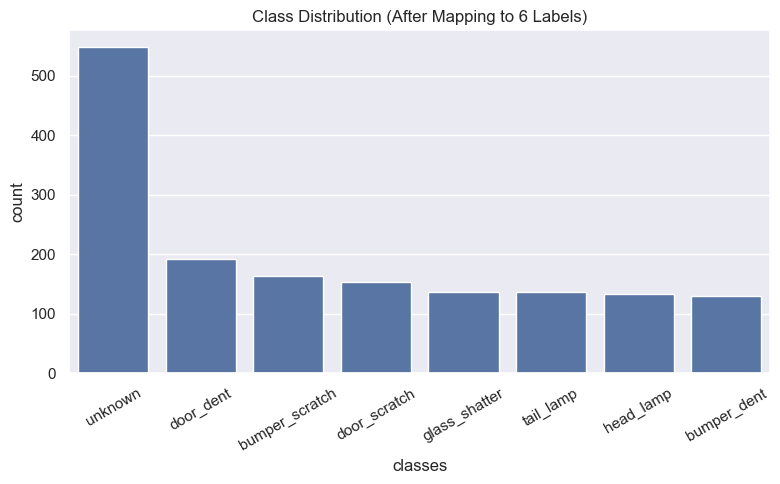

In [76]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="classes", order=df["classes"].value_counts().index)
plt.xticks(rotation=30)
plt.title("Class Distribution (After Mapping to 6 Labels)")
plt.tight_layout()
plt.show()


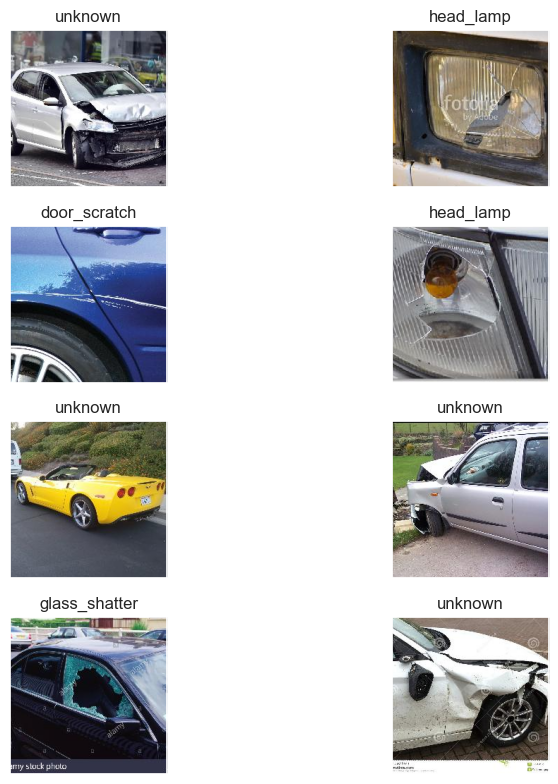

In [77]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(10, 8),
    subplot_kw={"xticks": [], "yticks": []},
)

for i, ax in enumerate(axes.flat):
    if i < len(df):
        img_path = build_full_path(df.image[i])
        ax.imshow(plt.imread(img_path))
        ax.set_title(df.classes[i])

plt.tight_layout()
plt.show()


In [78]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    shuffle=True,
    stratify=df["classes"],
    random_state=42
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train size:", len(train_df))
print("Test size:", len(test_df))


Train size: 1275
Test size: 319


In [79]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_IMG_DIR,
    x_col="image",
    y_col="classes",
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=0,
    subset="training",
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_IMG_DIR,
    x_col="image",
    y_col="classes",
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=0,
    subset="validation",
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=BASE_IMG_DIR,
    x_col="image",
    y_col="classes",
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)


Found 1020 validated image filenames belonging to 8 classes.
Found 255 validated image filenames belonging to 8 classes.
Found 319 validated image filenames belonging to 8 classes.


In [80]:
class StopAtAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get("accuracy", 0)
        val_acc = logs.get("val_accuracy", 0)

        if acc >= 0.95 and val_acc >= 0.95:
            print(f"Stopping early at epoch {epoch+1}: accuracy and val_accuracy ≥ 95%")
            self.model.stop_training = True


In [81]:
checkpoint_path = "efficientnet_best_6labels.keras"

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=15,
        factor=0.2,
        min_lr=1e-10
    ),
    ModelCheckpoint(
        checkpoint_path,
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    StopAtAccuracy()
]


In [82]:
# Build model with number of classes inferred from the generator
class_indices = train_gen.class_indices
num_classes = len(class_indices)

pretrained_model = EfficientNetV2S(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)

for layer in pretrained_model.layers[-30:]:
    layer.trainable = True

inputs = pretrained_model.input
x = GlobalAveragePooling2D()(pretrained_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)

outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Class indices: {'bumper_dent': 0, 'bumper_scratch': 1, 'door_dent': 2, 'door_scratch': 3, 'glass_shatter': 4, 'head_lamp': 5, 'tail_lamp': 6, 'unknown': 7}
Number of classes: 8


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        648 │ rescaling_2[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 112, 112,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 20,699,368 (78.96 MB)

 Trainable params: 20,542,424 (78.36 MB)

 Non-trainable params: 156,944 (613.06 KB)

In [85]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3646 - loss: 2.4928
Epoch 1: val_accuracy improved from 0.13725 to 0.48627, saving model to efficientnet_best_6labels.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 230s 7s/step - accuracy: 0.3645 - loss: 2.4926 - val_accuracy: 0.4863 - val_loss: 2.2024 - learning_rate: 1.0000e-04
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4318 - loss: 2.2426
Epoch 2: val_accuracy improved from 0.48627 to 0.61569, saving model to efficientnet_best_6labels.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 224s 7s/step - accuracy: 0.4328 - loss: 2.2406 - val_accuracy: 0.6157 - val_loss: 2.0146 - learning_rate: 1.0000e-04
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4921 - loss: 2.0333
Epoch 3: val_accuracy improved from 0.61569 to 0.63922, saving model to efficientnet_best_6labels.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 241s 8s/step - accuracy: 0.4925 - loss: 2.0332 - val_accuracy: 0.6392 - val_loss: 1.8914 - learning_rate: 1.0000e-04
Epoch 4